In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Data Acquisition

Steps followed to load the data
1) I created a folder yelp_Dataset in the working directory.
2) I downloaded the yelp dataset by clicking the 'download dataset' option on the webpage https://www.yelp.com/dataset
3) Unpacked the review and business .tar files using terminal command : tar xopf filename.tar
4) I moved yelp_academic_dataset_review.json and yelp_academic_dataset_business.json in the yelp_dataset folder 


In [44]:
#Please first use the steps above to download the data from the link provided
review_path = 'yelp_dataset/yelp_academic_dataset_review.json'
dfr_all = pd.read_json(review_path, lines=True)
dfr_all.columns


Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [45]:
business_path = 'yelp_dataset/yelp_academic_dataset_business.json'
dfb_all = pd.read_json(business_path, lines=True)
dfb_all.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

# The Project and its Justification 

Whenever we are at a new place or simply want to try out new cuisine, Yelp offers a great way to decide which restaurant to go to for a meal. Two important criteria that I usually consider in picking up the restaurant are 1) Number of reviews on that restaurant and 2) its Star Rating. 

In cases of doubt, I, like many others, would prefer a restaurant with a decent star rating (4.5) having lots of reviews (>200) over a restaurant with exceptionally high star-rating (5.0) but having less number of reviews (<100). In other words, no of reviews play an upper hand in our pick of the restaurant. However, the caveat is that the no of reviews a restaurant gets highly depends on its location in the city. As an example, consider a restaurant in a more popular location (popularity of the location could be due to many reasons - 1) is more touristy, 2) has large no of restaurants in general), it will get more customers than a restaurant in one of the suburbs close to the city outskirts and is therefore more likely to have higher number of reviews on Yelp. 

For my project, I am introducing a way of tweaking the Yelp's no. of reviews and star-rating system. I am using the total number of restaurants in every zipcode(postal_code feature in the dataset) as an indicator for the frequency of customers in those restaurants. I would give less weight to a restaurant if it is in a location already crowded with lots of other restaurants simply because it attracts the most crowd due its location. Thus, the end result will be a more accurate representation of the #of reviews and star-rating of a given restaurant. 

The location based #ofreviews and star-rating will allow the users to make a more informed choice if they are willing to explore the city for a great meal. 

In [248]:
#Extracting data from business.json of all the restaurants in the US that are open.
#I also added the condition that the postal code should contain digits only. Otherwise dataframe included some businesses in toronto having a state code 'OH' (although it should be 'ON', probably a mis-entry of data)

us_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dfb_trial = dfb_all[(dfb_all['categories'].str.contains('Restaurants', case=False, na=False, regex=True))& (dfb_all['is_open']==1) & dfb_all['state'].isin(us_states)& (dfb_all['postal_code'].str.isdigit())]

print('total no of restaurant reviews on yelp:',dfb_trial['review_count'].sum())
dfb_trial.groupby('city').agg({'business_id':['count'],'review_count':['sum']}).sort_values(by = ('review_count','sum'), ascending=False).head(10)


total no of restaurant reviews on yelp: 3363401


,business_id,review_count
,count,sum
city,,
Las Vegas,4374,1212683
Phoenix,2763,416197
Scottsdale,947,214816
Charlotte,2026,212597
Pittsburgh,1744,157512
Tempe,658,114190
Henderson,599,113537
Mesa,842,91105


I am considering 'Phoenix' city for my exploratory data analysis as it has the second highest no of businesses (from here on, I will refer to restaurants as businesses so that it is easier to relate to the actual feature in the dataset) that have been reviewed on yelp (12% of total) to ensure that I have enough data at hand. I didnt choose 'Las Vegas' as my test case as this city is primarily a holiday town and we might not observe the expected trends. However, this analysis can be later generalized to include cities like 'Las Vegas' that are heavily populated with tourists.   

In [162]:
#Preparing the clean review and business data frames
df_business = dfb_all[(dfb_all['categories'].str.contains('Restaurants', case=False, na=False, regex=True))& (dfb_all['is_open']==1) & (dfb_all['city'] == 'Phoenix') & (dfb_all['postal_code'].str.isdigit())]
all_ids = df_business['business_id']

df_revs = dfr_all[dfr_all['business_id'].isin(all_ids)]





Now, let us compare the total number of businesses vs the total number of reviews for a given postal code within the city of Phoenix. I am using the total number of businesses in a given pincode to estimate the type of location the business is in. This feature provides the best way to carry this analysis forward within the scope of the current data set. Later, a more precise indicator such as Google data could be incorporated for this purpose.

In [392]:
#Function to output top 5 values within a particular column of a data frame 
def sortcolumns(df,colname):
    return(df.sort_values(by=colname, ascending=False).head(5))

In [393]:

df_aggbusiness = df_business.groupby('postal_code')['business_id'].agg(['count']).reset_index() # Total #of businesses
print(df_aggbusiness.columns,'\n')

print('Total #of businesses')
print(sortcolumns(df_aggbusiness,'count'),'\n')

df_aggreview_ct = df_business.groupby('postal_code')['review_count'].agg(['sum']).reset_index()  # Total #of reviews

print('Total #of reviews')
print(sortcolumns(df_aggreview_ct,'sum'),'\n')

Index(['postal_code', 'count'], dtype='object') 

Total #of businesses
   postal_code  count
14       85016    181
27       85032    172
3        85004    160
16       85018    143
29       85034    127 

Total #of reviews
   postal_code    sum
14       85016  41958
3        85004  40072
16       85018  36376
10       85012  23998
27       85032  22697 



We can see that 4 out of top 5 postal codes crowded with restaurants a have higher number of net reviews from people. 

In [396]:
#Merge two data frames
df = pd.merge(df_aggbusiness, df_aggreview_ct, on='postal_code')

#Rename columns in merged dataframe to make them more intutive
df.rename(columns={"count": "no_of_business", "sum": "net_reviews"},inplace=True)

#Adding a new column containing an id associated with every postal code (for plotting purposes)
df['postal_ID'] = df.index +1
df

,postal_code,no_of_business,net_reviews,postal_ID
0,85001,9,85,1
1,85002,1,102,2
2,85003,57,18374,3
3,85004,160,40072,4
4,85005,3,488,5
...,...,...,...,...
59,85331,2,61,60
60,85335,1,24,61
61,85339,11,590,62
62,85353,1,22,63


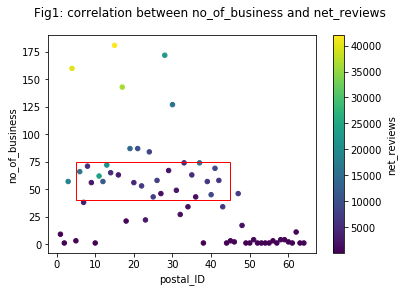

In [404]:
#Explore the correlation between 'no_of_business' and 'net_reviews' with a scatter plot
fig, ax = plt.subplots()
fig.suptitle('Fig1: correlation between no_of_business and net_reviews')
df.plot(kind='scatter',x='postal_ID', y='no_of_business', c='net_reviews',colormap='viridis',ax=ax)
rect = patches.Rectangle((5,40),40,35,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
fig.savefig('Asset1.png')
#ax.axhline(y=np.mean(df['no_of_business']), color='r', linestyle='dashed') #average no_of_businesses in a postal code

Unsurpisingly, Fig 1 shows that postal codes with most businesses have the most no. of review counts. Now let us see this more clearly by looking at the histogram of the number of review counts in a postal code with 181 businesses (max no of businesses in a given postal code in this city). 

Notice that, on an average, a postal code in this city has 50-70 restaurants (data points in the red rectangle in Fig 1).

In [442]:
#List postal codes having businesses within the red rectangle in Fig 1 i.e. between 50-70
df[(df['no_of_business'] >= 50) & (df['no_of_business'] <= 70)].head(5)

,postal_code,no_of_business,net_reviews,postal_ID
2,85003,57,18374,3
5,85006,66,16479,6
8,85009,56,2591,9
10,85012,62,23998,11
11,85013,57,11394,12


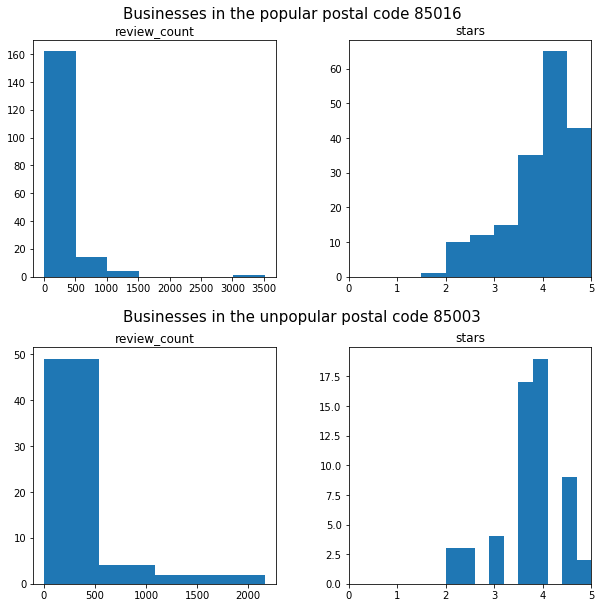

In [451]:
# Postal code with 181 restaurants (max number of businesses for a given postal code in the city)
df_max = df_business[df_business['postal_code'] == '85016']

fig2, ax2 = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
df_max.hist('review_count',grid=False,bins=7,ax=ax2[0,0])
df_max.hist('stars',grid=False,bins=7,ax=ax2[0,1])
ax2[0,1].set_xlim(0,5)
fig2.text(0.25, 0.91 , "Businesses in the popular postal code 85016" ,size=15.0)

# Example of a postal code with 57 restaurants - representative of the 'average location in the city'
df85003 = df_business[df_business['postal_code'] == '85003']

df85003.hist('review_count',grid=False,bins=4,ax=ax2[1,0])
df85003.hist('stars',grid=False,ax=ax2[1,1])
ax2[1,1].set_xlim(0,5)
fig2.text(0.25, 0.49 , "Businesses in the unpopular postal code 85003" ,size=15.0)
plt.show()
fig2.savefig('Asset2.png')

We can easily see that the values on the y axis in the review_count histogram have significantly dropped in second case i.e. for the postal code which is more representative of a typical location in the city. The postal code 85016 is among the city's popular locations for food options and therefore attracts more people than the postal code 85003. Moreover, the postal code 85016 also has a large number of 4 or higher star rated businesses.


In [403]:

print(df_max[df_max['stars'].astype(float)> 4.0]['review_count'].sum()) # net reviews for businesses with stars> 4
print(df_max['review_count'].sum(),'\n') # net reviews for all businesses in postal code 85016


print(df85003[df85003['stars'].astype(float)> 4.0]['review_count'].sum()) # net reviews for businesses with stars> 4
print(df85003['review_count'].sum()) # net reviews for all businesses in postal code 85003

9636
41958 

5802
18374


# Conclusion

Now, lets analyze the 'stars' histogram for the two postal codes. The peaks of the histograms show that there are higher number of 4 or higher star rating businesses for the postal code more crowded with restaurants (85016). However, a simple calculation points out that only 22% of businesses in postal code 85016 are rating 4 and above, while about 31% of restaurants in postal code 85003 are rating 4 and above. 

This suggests that even though, higher number of people tend to visit the restaurants in the neighbourhood 85016, it is more likely that one would find a good restaurant in the neighbourhood 85003 (the one that is not as popular for restaurants).

Therefore, the revised rating and review count of the restaurant on the basis of the postal code it is in will provide more insight about the true review of that restaurant.